# Quantum dimension of machine learning 

*~ QubitFreaks*

---

[Abstrakt tutorialu o uczeniu maszynowym, wstęp]

# 🛫 Getting started
## 🛒 Install requirements from a file 

In [ ]:
!pip install -r ./requirements.txt

## 📃 Generate a sample data for training and testing

In [7]:
# Imports for data loader & vizualizations 
from sklearn.datasets import make_moons

# Randomly choosen number to init randomness
random_seed = 1829

X, y = make_moons(
    n_samples=200, # Defining number of samples to generate
    noise=.08, # Noise is the value of how much points will be scattered on graph 
    random_state=random_seed
)

# Print shapes of generated datasets
X.shape, y.shape

((200, 2), (200,))

#### `X`:
We just generated **200** `samples` (arrays), each with **two** values. The both values of every `sample` represent thier one distinguishing feature. It's stored in `X` variable.
#### `y`:
`y` is array of {`0`, `1`} values (like: `[0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0]`) which determinate to which class belong every sample from X. (With the same order)

Let's graph that data 📊:

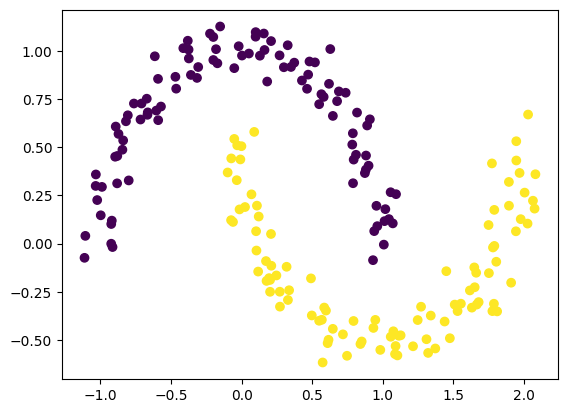

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt 

plt.scatter(X[:,0], X[:,1], c=y)



We can do that by "drawing" a line between these two groups of points. 

Here is classic and basic method for that called **linear regression**. It's implemented in SVC classical alghoritm (nothing from quantum computing yet)

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=random_seed)

X.shape, X_train.shape, X_test.shape

((200, 2), (160, 2), (40, 2))

In [20]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

In [21]:
feature_dimension = len(X[0]) # number of features in X data (=2)

dataset_feature_map = ZZFeatureMap(
    feature_dimension=feature_dimension, 
    reps=5, 
    entanglement='full' # full / linear entanglement of qubits
)

sampler=Sampler()
fidelity=ComputeUncompute(sampler=sampler)

# Creating a quantum kernel 
quantum_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=dataset_feature_map) 

C:\Users\jozek\AppData\Local\Temp\ipykernel_14512\3007762759.py:9: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler=Sampler()


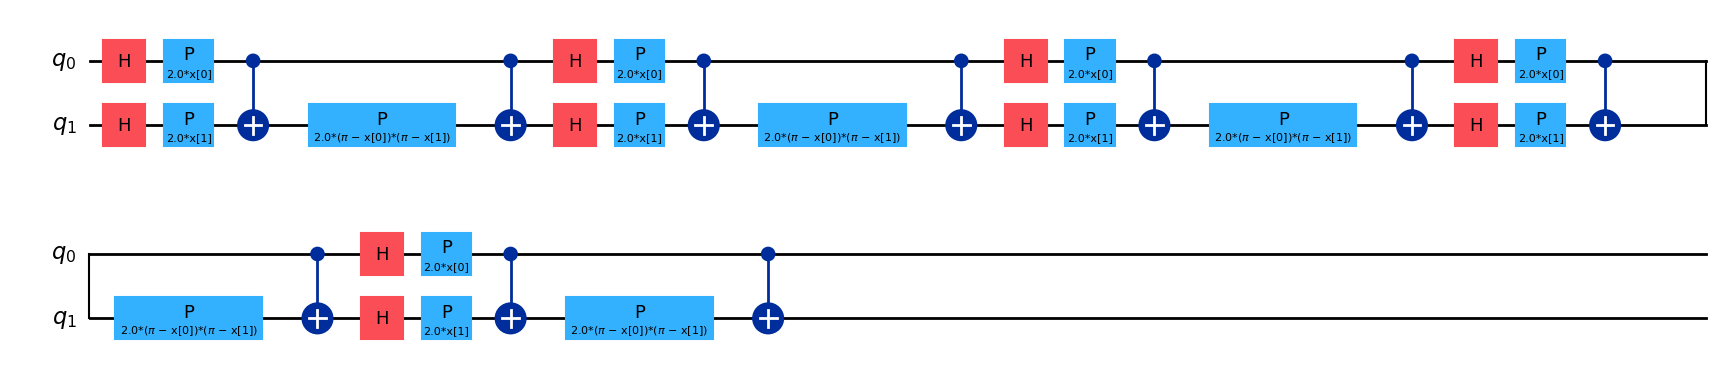

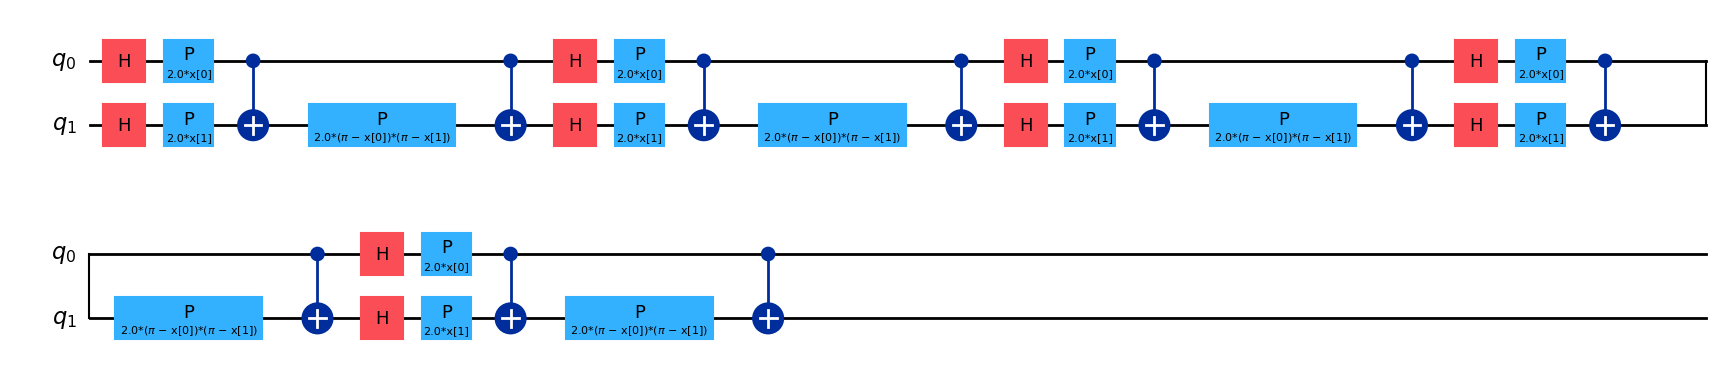

In [22]:
from qiskit.visualization import circuit_drawer
circuit_drawer(dataset_feature_map.decompose(), output='mpl')

In [25]:
%%time
moon_matrix_train = quantum_kernel.evaluate(x_vec=X_train) 
moon_matrix_test = quantum_kernel.evaluate(x_vec=X_test, y_vec=X_train)

CPU times: total: 1min 43s
Wall time: 5min 16s


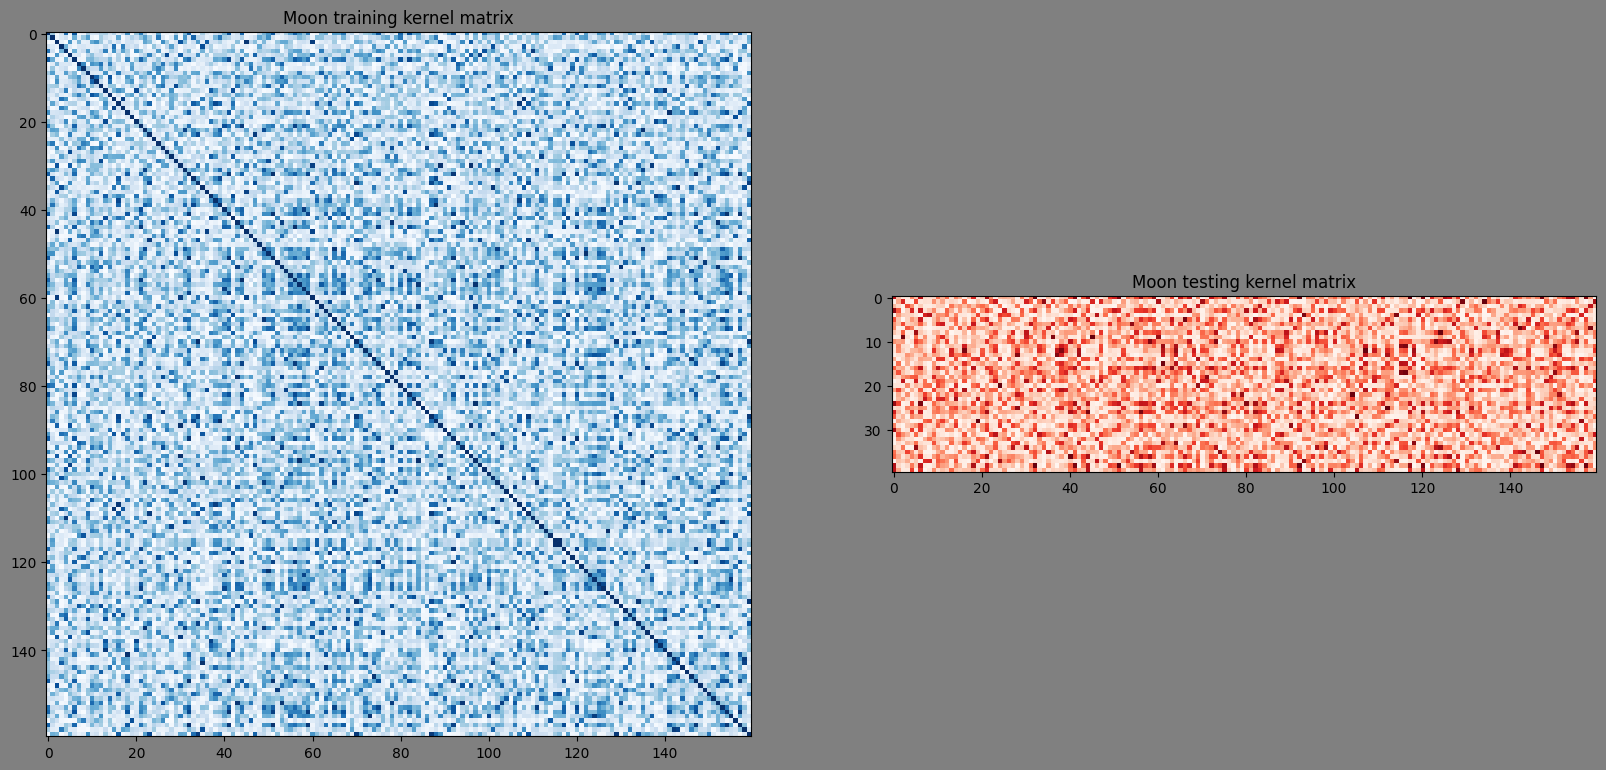

In [26]:
import numpy as np

fig, axs = plt.subplots(1, 2, figsize=(20, 10), facecolor='grey')

axs[0].imshow(
    np.asmatrix(moon_matrix_train), 
    interpolation="nearest", 
    origin="upper", 
    cmap="Blues"
)
axs[0].set_title("Moon training kernel matrix")

axs[1].imshow(
    np.asmatrix(moon_matrix_test), 
    interpolation="nearest", 
    origin="upper", 
    cmap="Reds"
)
axs[1].set_title("Moon testing kernel matrix")

plt.show()

### Wyjaśnienie
#### `Moon training kernel matrix`
Wartości na osi $x$ i wartości na osi $y$ są takie same, a gradient kolorów pikseli reprezentje poziom podobieństwa ich wartości.

Kolor **granatowy** = *takie same*, kolor **biały** = *zupełnie różne*. 

Zgodnie z powyższym, piksele znajdujące się na współrzędnych $x=y$ są granatowe, ponieważ porównywane są te same wartości, w wyniku czego powstaje linia przekątna. 

#### `Moon testing kernel matrix`
Tutaj porównywane jest podobieństwo danych treningowych (oś $x$) z danymi testowymi (oś $y$)

In [28]:
%%time
from qiskit_machine_learning.algorithms import QSVC

qsvc = QSVC(quantum_kernel=quantum_kernel)
qsvc.fit(X_train, y_train)
qsvc_score = qsvc.score(X_test, y_test)

print(f"QSVC classification test score: {qsvc_score*100}%")

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 10)
yy = np.linspace(ylim[0], ylim[1], 10)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = qsvc.decision_function(xy).reshape(XX.shape)

ax.contourf(XX, YY, Z, levels=[Z.min(), 0, Z.max()], colors=['#FFAAAA', '#AAAAFF'], alpha=0.8)
ax.contour(XX, YY, Z, colors='k', levels=[0], linewidths=2)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
plt.title('QSVC Decision Boundary with Colored Regions')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()